In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split





# Utility Functions


plot the data distribution


In [132]:
def plot_distribution(data, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of column {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


box plot


In [133]:
def plot_box_strip(data, column):
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[column], color='lightcoral')
    plt.title(f'Boxplot of {column}')
    plt.show()


scatter plot + box plot for visualizing the target column vs features


In [134]:

def plot_target_vs_numerical_grid(df, target, num_features, cols=2):
    rows = math.ceil(len(num_features) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(num_features):
        unique_vals = df[col].nunique()
        
        if unique_vals == 2:
            # Use boxplot for binary features
            sns.boxplot(x=df[col].astype(str), y=df[target], ax=axes[i])
            axes[i].set_xlabel(f'{col} (binary)')
        else:
            # Use scatterplot for continuous features
            sns.scatterplot(x=df[col], y=df[target], alpha=0.6, ax=axes[i])
            # sns.regplot(x=df[col], y=df[target], scatter=False, color='red', ax=axes[i])
            axes[i].set_xlabel(col)

        axes[i].set_title(f'{target} vs {col}')
        axes[i].set_ylabel(target)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
# box plot for categorical features
def plot_target_vs_categorical(df, target, cat_features):
    for col in cat_features:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col], y=df[target], palette='Set2')
        plt.title(f'{target} by {col}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.xticks(rotation=45)
        plt.show()


correlation heatmap


In [135]:
def correlation_heatmap(df, target):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr[[target]].sort_values(by=target, ascending=False), annot=True, cmap='coolwarm')
    plt.title(f'Correlation with {target}')
    plt.show()


correlation matrix


In [136]:
def plot_correlation_matrix(df):
    corr_matrix = df.corr(numeric_only=True)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix")
    plt.show()

### Reading the data + some aggregation


In [137]:
dataset = pd.read_csv('data/servo.data', header=None)

In [138]:
dataset.head()

,0,1,2,3,4
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [139]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       167 non-null    object 
 1   1       167 non-null    object 
 2   2       167 non-null    int64  
 3   3       167 non-null    int64  
 4   4       167 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.7+ KB


no missing values


In [140]:
dataset.describe()

,2,3,4
count,167.000000,167.000000,167.000000
mean,4.155689,2.538922,1.389708
std,1.017770,1.369850,1.559635
min,3.000000,1.000000,0.131250
25%,3.000000,1.000000,0.503126
50%,4.000000,2.000000,0.731254
75%,5.000000,4.000000,1.259369
max,6.000000,5.000000,7.100108


In [141]:
dataset.columns

Index([0, 1, 2, 3, 4], dtype='int64')

# The column names


As described in the servo.names file:

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10


Renaming the columns for better readability


In [142]:
dataset = dataset.rename(
    columns={
        0: 'motor',
        1: 'screw',
        2: 'pgain',
        3: 'vgain',
        4: 'y'
    }
)

In [143]:
num_features = dataset.select_dtypes(include=np.number).columns.drop('y').tolist()
cat_features = dataset.select_dtypes(exclude=np.number).columns.tolist()


# Encoding


encoding categorical features with One-Hot encoding


In [144]:
dataset_encoded = pd.get_dummies(dataset, columns=cat_features, drop_first=True)


## Scaling


In [145]:
scaler = StandardScaler()

# Exclude 'y' column from scaling
features = dataset_encoded.drop('y', axis=1)
scaled_features = scaler.fit_transform(features)

# Replace the features with the scaled values, and keep 'y' as is
data = pd.DataFrame(scaled_features, columns=features.columns)
data['y'] = dataset_encoded['y'].values


# Visualization


visualize features with the target


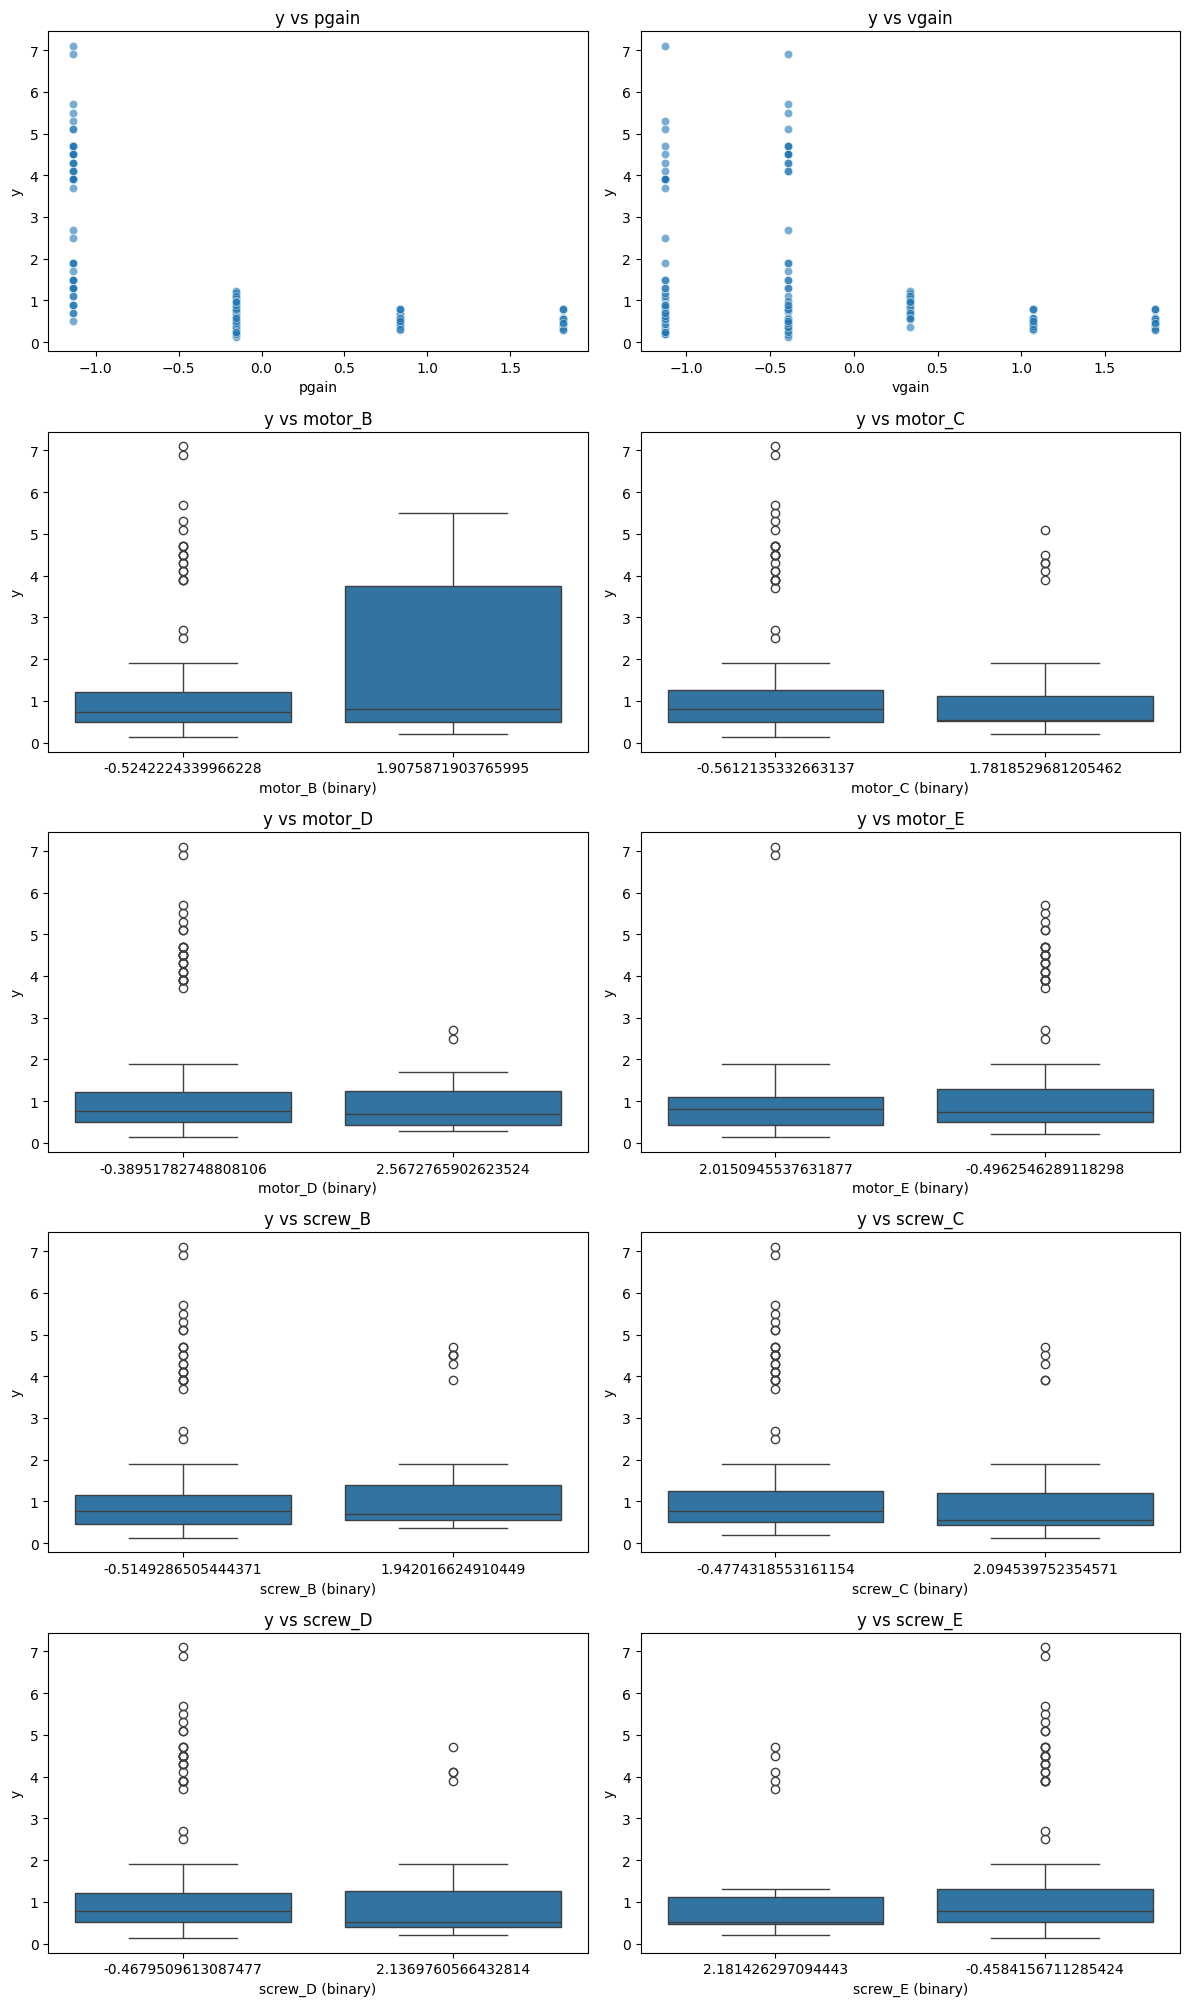

In [146]:
plot_target_vs_numerical_grid(data, 'y', data.drop(columns=['y']))

correlation matrix


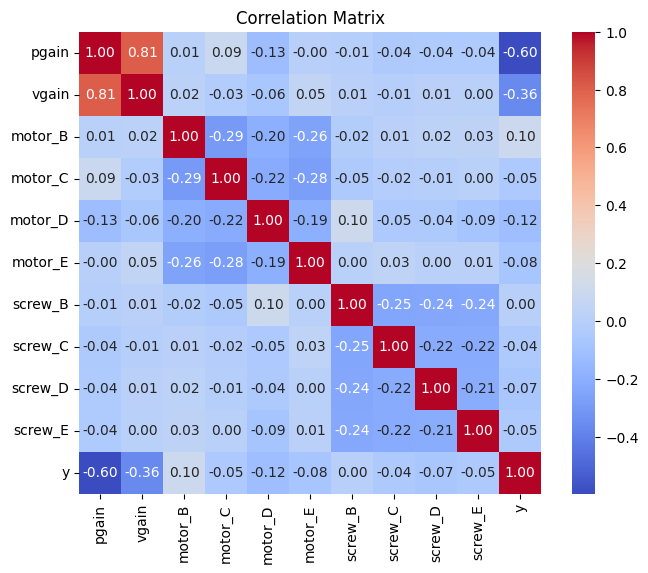

In [147]:
plot_correlation_matrix(data)

#### Note:


There's high correlation between pgain and vgain


vgain has less correlation with the target y(-0.36) than pgain (-0.60)

==> we can drop the vgain column, especially for linear regression.
But not necessary for tree based models, or any models that do not use weights


In [148]:
data = data.drop('vgain', axis=1)

In [149]:
data.columns

Index(['pgain', 'motor_B', 'motor_C', 'motor_D', 'motor_E', 'screw_B',
       'screw_C', 'screw_D', 'screw_E', 'y'],
      dtype='object')

## Splitting the data for train and test


In [150]:
X = data.drop('y', axis=1)
y = data['y']

In [151]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train a Linear Regression Model


In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()


In [153]:
model.fit(X_train, y_train)


LinearRegression()

### model coefficients


In [154]:
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef}")


pgain: -0.9733405345028697
motor_B: 0.015377791131366947
motor_C: -0.12350605444380416
motor_D: -0.4113131470195485
motor_E: -0.21206529172579036
screw_B: -0.23506385444042693
screw_C: -0.3386784219429218
screw_D: -0.42717603532242987
screw_E: -0.3654525731185619


In [155]:
y_pred = model.predict(X_test)


In [156]:

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 1.2521
R² Score: 0.4824
